## Rešavanje problema simboličke regresje upotrebom genetičkog progamiranja

Simbolička regresija predstavlja pronalaženje matematičkog izraza koji najbolje opisuje ulazne parametre.
Problem je rešen pomoću biblioteke deap.

In [4]:
import operator
import math
import random
import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [ ]:
# Maksimalan broj generacija
no_generations = 30

# Veličina populacije
no_population = 300

# Broj jedinki koje će učestvovati u turnirskoj selekciji
no_tournaments = 5

# Verovatnoća ukrštanja
p_xo = 0.7

# Verovatnoća mutacije
p_m  = 0.3

# Naziv ciljne funkcije simboličke regresije
index_func = 'sin-lin'

# Koja metrika greške će se koristiti (Apsolutna ili kvadratna)
UseSqError = True

# Raspodela verovatnoće 
def gauss(mu, sigma, x):
    return 1/(sigma * math.sqrt(2 * math.pi)) * math.exp(-1/2*((x-mu)/sigma)**2)

# Definisanje ciljnih funkcija simboličke regresije
def Problem(x):
    switcher = {
        'x^2': lambda x: x**2 - 5*x,
        'x^4': lambda x: x**4 + x**3 + x**2 + x,
        'x^6': lambda x: (x**6)-2*(x**4) + (x**2),
        'sin-lin': lambda x: math.sin(math.pi/4+2*x),
        'sin-3': lambda x: math.sin(3*(x**3)-(x**2)/7),
        'N(0,1)': lambda x: gauss(mu=0, sigma=1, x=x),
    }

    func = switcher.get(index_func, lambda: "nothing")
    return func(x)

#  Kreiranje test tačaka za evaluaciju funkcija, tačke se nalaze u rasponu od [-Pi, Pi]
test_points = numpy.linspace(-math.pi,math.pi, 180).tolist();

# Definisanje nove funkcije koja omogućava zaštićeno deljenje
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

# Definišu se funkcije koje će se nalaziti u čvorovima stabla i terminali koji će se nalaziti u listu 
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addTerminal(1)
pset.addTerminal(-1)    

# Preimenovanje argumenta funkcije u x
pset.renameArguments(ARG0='x')

# FitnessMin govori o kom problemu se radi, u ovom slucaju radi se o minimalizovanju iz tog razloga je težina -1
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# Kreiraju se jedinke, bice predstavljene strukturom stabla
# Kao funkcija prilagodjenosti koristi se FitnesMin metoda
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Evaluacija(Izračunavanje) vrednosti (Funkcija prilagođenosti)
def evalSymbReg(individual, points):
    func = toolbox.compile(expr=individual)

    if UseSqError:
      # Apsolutna distanca između ciljne funkcije i  rešenja
       error = (abs(func(x) - Problem(x)) for x in points)
    else:
      # Kvadratna greška
       error = (abs(func(x) - Problem(x))**2 for x in points)

    return math.fsum(error),

# Deklarisanje genetičkih operatora
toolbox.register("evaluate", evalSymbReg, points=test_points)
# Turnirska selekcija reporodukcije
toolbox.register("select", tools.selTournament, tournsize=no_tournaments)
# Ukrštsnje u jednoj  tački
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Inicijalizacija random stanja
random.seed(318)
random.seed()

# Kreiranje populacije
pop = toolbox.population(n=no_population)
# Čuvanje najbolje jedinke za dalju reprodukciju
hof = tools.HallOfFame(1)

# Statistika
# U statistici ce se koristiti fitness funkcija svakog elementa
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
# Izračunavanja se kombinuju nad različitm atributima kao što su veličina populacije, fitness vrednosti.. 
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("mdn", numpy.median)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# Pokretanje procesa evolucije
pop, log = algorithms.eaSimple(pop, toolbox, p_xo, p_m, no_generations, stats=mstats,
                                       halloffame=hof, verbose=False)
# Ako verbose True onda cuvamo i printamo statistiku, da li zelimo da posmatramo sta se desava sa statistikom 

In [ ]:
# Reprezentacija najbolje jedinke
print(hof[0])

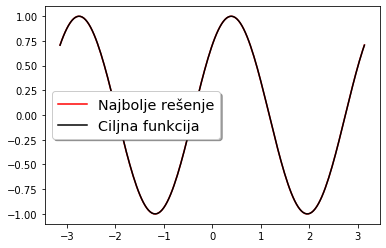

In [286]:
# Tačke za testiranje
x = test_points
f = toolbox.compile(expr=hof[0])
y = numpy.empty(len(x))
# Izračunata vrednost najbolje jedinke
for i in range(len(x)): y[i] = f(x[i])

Y = numpy.empty(len(x))
# Izračunata vrednost ciljne funkcije
for i in range(len(x)): Y[i] = Problem(x[i])
    
from matplotlib import pyplot
fig, ax = pyplot.subplots()
ax.plot(x, y, 'r-', label='Najbolje rešenje')
ax.plot(x, Y, 'k-', label='Ciljna funkcija')
legend = ax.legend(shadow=True, fontsize='x-large')

pyplot.show()